# Recurrent neural networks for H.P Lovecraft text generation

"The color out of space" is one of my favorite tales from Lovecraft, i will use it(as well as others as the call of cthulhu) to create a recurrent neural network in tensorflow that learns his style and generates new text in his style

This network is based off of Andrej Karpathy's [post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) and [implementation in Torch](https://github.com/karpathy/char-rnn) and an example from "Deep Learning Nanodegree" on udacity. Also, some information [here at r2rt](http://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html) and from [Sherjil Ozair](https://github.com/sherjilozair/char-rnn-tensorflow) on GitHub. 

## General architecture using "Long short term memory" units in the recurrent layers

<img src="assets/charseq.jpeg" width="500">

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time
from collections import namedtuple

import numpy as np
import tensorflow as tf
from nltk.tokenize import word_tokenize
import nltk
import itertools
import matplotlib.pyplot as plt
from time import gmtime, strftime ,localtime

In [3]:
# Run only the  first time nltk is used to download language
#nltk.download()

### Define conf variables and hyper parameteters 

In [4]:
mode = "words" #characters or words

epochs = 500
batch_size = 128       # Sequences per batch
num_steps = 32         # Number of sequence steps per batch
lstm_size = 512         # Size of hidden layers in LSTMs
num_layers = 2          # Number of LSTM layers
learning_rate = 0.0001    # Learning rate
keep_prob = 0.5       # Dropout keep probability

resume_from_checkpoint = False

### Define base text
Once trained ,the network can take base text and a sequence size and generate new text using base text as first characters in the sequence. For every element in base text wi will create a list that will store generated text as training goes, to be able to compare results between steps

In [5]:
text_to_try = ["In the first place","the night before","horror","creature","night","dream","thing","That night","mountain","Ammi","Cthulhu","raven","bird","nevermore","dead","The bird"]

#### Function that separates text into tokens(for whitespace characters, only new line is implemented, missing tabs and others=

In [6]:
def tokenize_by_words(text):
    text = text.replace("\n"," new_line_token ")
    tokens = []
    splitted =[[word_tokenize(w),' ']for w in text.split()]
    splitted = list(itertools.chain(*list(itertools.chain(*splitted))))
    
    token_list = []
    i = 0
    while i < len(splitted):
        if splitted[i] == "new_line_token":
            if   token_list[-1]==" ":
                token_list[-1] = splitted[i]
            else:
                token_list.append(splitted[i])
            i+=1
        else:
            token_list.append(splitted[i])
        i+=1
    
    return token_list

def tokenize_by_characters(text):
    return list(text)

def tokenize_text(text,mode="characters"):
    if mode == "characters":
        return tokenize_by_characters(text)
    elif mode == "words":
        return tokenize_by_words(text)
    
tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala",mode)
#tokenize_text("Hello, my name is Luis Leal!\n\nFrom Guatemala","words")


['Hello',
 ',',
 ' ',
 'my',
 ' ',
 'name',
 ' ',
 'is',
 ' ',
 'Luis',
 ' ',
 'Leal',
 '!',
 'new_line_token',
 'new_line_token',
 'From',
 ' ',
 'Guatemala',
 ' ']

First we'll load the text file and convert it into integers for our network to use. Here I'm creating a couple dictionaries to convert the characters to and from integers. Encoding the characters as integers makes it easier to use as input in the network.

In [7]:
with open('corpus.txt', 'r') as f:
    text=f.read()

In [8]:
vocab = set(tokenize_text(text,mode))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))

### Get a little portion of text for validation

In [9]:
tokenized_text = tokenize_text(text,mode)
encoded_dataset = np.array([vocab_to_int[c] for c in tokenized_text if c in vocab_to_int], dtype=np.int32)

In [10]:
validation_size = batch_size * num_steps #create a single baty
validation_start_index = len(encoded_dataset) - validation_size

encoded = encoded_dataset[:validation_start_index]
encoded_val = encoded_dataset[validation_start_index:]

In [11]:
def encoded_to_text(encoded):
    return "".join([int_to_vocab[number] for number in encoded])

print(encoded_to_text(encoded_val[0:100]))

at least five thousand years have elapsed since your entombment, I take it for granted that your histories at that period, if not your traditions were sufficiently explicit on that one topic of universal interest, the Creation, which took place, as I presume you are aware, only 


In [12]:
val_text =encoded_to_text(encoded_val)
text = encoded_to_text(encoded)

Let's check out the first 100 characters of train and validation, make sure everything is peachy.  line of a book ever.

In [13]:
text[:100]

'THE COLOUR OUT OF SPACEnew_line_tokennew_line_tokenWest of Arkham the hills rise wild, and there are'

In [14]:
val_text[:100]

'at least five thousand years have elapsed since your entombment, I take it for granted that your his'

And we can see the characters encoded as integersin both train and validation

In [15]:
encoded[:100]

array([ 3718,  8241,  7468,  8241,  7423,  8241,  6732,  8241, 17910,
        3121,  3121,  1020,  8241, 13915,  8241, 14976,  8241, 13656,
        8241,  7517,  8241,  5968,  8241,  3168,  5682,  8241, 21102,
        8241, 20836,  8241, 25663,  8241, 14899,  8241, 22166,  8241,
       16925,  8241,  6233,  8241,  1134,  8241, 25171,  8241, 25907,
        8241,  3167,  8241,  4105,  8241, 17906, 19206,  8241,   660,
        8241, 25663,  8241, 21700,  8241,  4674,  8241,  5081,  8241,
       25629,  8241, 13656,  8241, 16071,  8241, 12376,  8241, 27091,
        5682,  8241, 21102,  8241, 25629,  8241, 18608,  8241, 13022,
        8241,  7078,  8241, 23250,  8241,  4105,  8241, 20574,  8241,
        8329,  8241, 13656,  8241,   282,  8241, 13915,  8241, 20718, 19206], dtype=int32)

In [16]:
encoded_val[0:100]

array([26893,  8241,  3819,  8241, 23151,  8241, 26176,  8241,  6012,
        8241,  7424,  8241,  5430,  8241, 19340,  8241, 17161,  8241,
       14399,  5682,  8241, 23143,  8241, 23953,  8241, 26068,  8241,
        2086,  8241,  1797,  8241,  1134,  8241, 17161,  8241,  4512,
        8241, 26893,  8241,  1134,  8241,  4617,  5682,  8241, 21923,
        8241, 23646,  8241, 17161,  8241, 25548,  8241,  6741,  8241,
        8849,  8241, 27422,  8241,  3426,  8241,  1134,  8241, 27396,
        8241, 22455,  8241, 13915,  8241, 14385,  8241, 24745,  5682,
        8241, 13656,  8241, 10099,  5682,  8241,  1976,  8241, 12372,
        8241,  1864,  5682,  8241,  7451,  8241, 23143,  8241,  3043,
        8241, 11263,  8241, 25663,  8241, 17033,  5682,  8241, 21105,  8241], dtype=int32)

Since the network is working with individual english tokens, it's similar to a classification problem in which we are trying to predict the next character from the previous text.  Here's how many 'classes' our network has to pick from.

In [17]:
len(vocab)

28404

## Making training mini-batches

Here is where we'll make our mini-batches for training. Remember that we want our batches to be multiple sequences of some desired number of sequence steps. Considering a simple example, our batches would look like this:

<img src="assets/sequence_batching@1x.png" width=500px>


<br>
We have our text encoded as integers as one long array in `encoded`. Let's create a function that will give us an iterator for our batches. I like using [generator functions](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/) to do this. Then we can pass `encoded` into this function and get our batch generator.

The first thing we need to do is discard some of the text so we only have completely full batches. Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences) and $M$ is the number of steps. Then, to get the number of batches we can make from some array `arr`, you divide the length of `arr` by the batch size. Once you know the number of batches and the batch size, you can get the total number of characters to keep.

After that, we need to split `arr` into $N$ sequences. You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences (`n_seqs` below), let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$ where $K$ is the number of batches.

Now that we have this array, we can iterate through it to get our batches. The idea is each batch is a $N \times M$ window on the array. For each subsequent batch, the window moves over by `n_steps`. We also want to create both the input and target arrays. Remember that the targets are the inputs shifted over one character. You'll usually see the first input character used as the last target character, so something like this:
```python
y[:, :-1], y[:, -1] = x[:, 1:], x[:, 0]
```
where `x` is the input batch and `y` is the target batch.

The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of steps in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `n_steps` wide.

In [18]:
def get_batches(arr, n_seqs, n_steps):
    '''Create a generator that returns batches of size
       n_seqs x n_steps from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       n_seqs: Batch size, the number of sequences per batch
       n_steps: Number of sequence steps per batch
    '''
    # Get the batch size and number of batches we can make
    batch_size = n_seqs * n_steps 
    n_batches =  len(arr)//batch_size
    
    # Keep only enough characters to make full batches
    arr =  arr[:n_batches*batch_size]
    
    # Reshape into n_seqs rows
    arr = arr.reshape((n_seqs,-1))
    
    for n in range(0, arr.shape[1], n_steps):
        # The features
        x = arr[:,n:n+n_steps]
        # The targets, shifted by one
        y = np.zeros(x.shape)
        y[:,:-1],y[:,-1] = x[:,1:] ,x[:,0]
        yield x, y

Now I'll make my data sets and we can check out what's going on here. Here I'm going to use a batch size of 10 and 50 sequence steps.

In [19]:
batches = get_batches(encoded, 10, 50)
x, y = next(batches)

In [20]:
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[ 3718  8241  7468  8241  7423  8241  6732  8241 17910  3121]
 [ 5682  8241 13439  8241 12395  8241 13915  8241 24945  8241]
 [ 8241 13915  8241 13656  8241  5052  8241 18004  8241 24993]
 [ 8241 27006  8241  6631  8241 27396  8241 13915  8241 13656]
 [21102  8241  8872  8241  8969  8241  9075  8241 13656  8241]
 [ 8241  4750  8241  1711  8241 13164  5682  8241  8339  3121]
 [22166  8241 13656  8241 24775  8241 26584  8241  2086  8241]
 [ 8241 13656  8241  4068  8241 13915  8241 13656  8241 26554]
 [14451  8241 15521  8241  1976  8241 23143  8241 24286  8241]
 [ 8241 25171  8241 13675  8241 10741 19206  8241  8189  8241]]

y
 [[  8241.   7468.   8241.   7423.   8241.   6732.   8241.  17910.   3121.
    3121.]
 [  8241.  13439.   8241.  12395.   8241.  13915.   8241.  24945.   8241.
   22472.]
 [ 13915.   8241.  13656.   8241.   5052.   8241.  18004.   8241.  24993.
    5682.]
 [ 27006.   8241.   6631.   8241.  27396.   8241.  13915.   8241.  13656.
    8241.]
 [  8241.   8872.   82

## Building the model

Below is where you'll build the network. We'll break it up into parts so it's easier to reason about each bit. Then we can connect them up into the whole network.

<img src="assets/charRNN.png" width=500px>


### Inputs

First off we'll create our input placeholders. As usual we need placeholders for the training data and the targets. We'll also create a placeholder for dropout layers called `keep_prob`. This will be a scalar, that is a 0-D tensor. To make a scalar, you create a placeholder without giving it a size.

In [21]:
def build_inputs(batch_size, num_steps):
    ''' Define placeholders for inputs, targets, and dropout 
    
        Arguments
        ---------
        batch_size: Batch size, number of sequences per batch
        num_steps: Number of sequence steps in a batch
        
    '''
    # Declare placeholders we'll feed into the graph
    inputs = tf.placeholder(tf.int32,[batch_size,num_steps],name="inputs")
    targets = tf.placeholder(tf.int32,[batch_size,num_steps],name="targets")
    
    # Keep probability placeholder for drop out layers
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    
    return inputs, targets, keep_prob

### LSTM Cell

Here we will create the LSTM cell we'll use in the hidden layer. We'll use this cell as a building block for the RNN. So we aren't actually defining the RNN here, just the type of cell we'll use in the hidden layer.

We first create a basic LSTM cell with

```python
lstm = tf.contrib.rnn.BasicLSTMCell(num_units)
```

where `num_units` is the number of units in the hidden layers in the cell. Then we can add dropout by wrapping it with 

```python
tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
```
You pass in a cell and it will automatically add dropout to the inputs or outputs. Finally, we can stack up the LSTM cells into layers with [`tf.contrib.rnn.MultiRNNCell`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/MultiRNNCell). With this, you pass in a list of cells and it will send the output of one cell into the next cell. For example,

```python
tf.contrib.rnn.MultiRNNCell([cell]*num_layers)
```

This might look a little weird if you know Python well because this will create a list of the same `cell` object. However, TensorFlow will create different weight matrices for all `cell` objects. Even though this is actually multiple LSTM cells stacked on each other, you can treat the multiple layers as one cell.

We also need to create an initial cell state of all zeros. This can be done like so

```python
initial_state = cell.zero_state(batch_size, tf.float32)
```


In [22]:
def build_lstm(lstm_size, num_layers, batch_size, keep_prob):
    ''' Build LSTM cell.
    
        Arguments
        ---------
        keep_prob: Scalar tensor (tf.placeholder) for the dropout keep probability
        lstm_size: Size of the hidden layers in the LSTM cells
        num_layers: Number of LSTM layers
        batch_size: Batch size

    '''
    ### Build the LSTM Cell
    # Use a basic LSTM cell
    # Add dropout to the cell outputs
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper( tf.contrib.rnn.BasicLSTMCell(lstm_size),output_keep_prob = keep_prob) for _ in range(num_layers)])
    initial_state = cell.zero_state(batch_size,tf.float32)
    
    return cell, initial_state

### RNN Output

Here we'll create the output layer. We need to connect the output of the RNN cells to a full connected layer with a softmax output. The softmax output gives us a probability distribution we can use to predict the next character, so we want this layer to have size $C$, the number of classes/characters we have in our text.

If our input has batch size $N$, number of steps $M$, and the hidden layer has $L$ hidden units, then the output is a 3D tensor with size $N \times M \times L$. The output of each LSTM cell has size $L$, we have $M$ of them, one for each sequence step, and we have $N$ sequences. So the total size is $N \times M \times L$. 

We are using the same fully connected layer, the same weights, for each of the outputs. Then, to make things easier, we should reshape the outputs into a 2D tensor with shape $(M * N) \times L$. That is, one row for each sequence and step, where the values of each row are the output from the LSTM cells. We get the LSTM output as a list, `lstm_output`. First we need to concatenate this whole list into one array with [`tf.concat`](https://www.tensorflow.org/api_docs/python/tf/concat). Then, reshape it (with `tf.reshape`) to size $(M * N) \times L$.

One we have the outputs reshaped, we can do the matrix multiplication with the weights. We need to wrap the weight and bias variables in a variable scope with `tf.variable_scope(scope_name)` because there are weights being created in the LSTM cells. TensorFlow will throw an error if the weights created here have the same names as the weights created in the LSTM cells, which they will be default. To avoid this, we wrap the variables in a variable scope so we can give them unique names.


In [23]:
def build_output(lstm_output, in_size, out_size):
    ''' Build a softmax layer, return the softmax output and logits.
    
        Arguments
        ---------
        
        lstm_output: List of output tensors from the LSTM layer
        in_size: Size of the input tensor, for example, size of the LSTM cells
        out_size: Size of this softmax layer
    
    '''

    # Reshape output so it's a bunch of rows, one row for each step for each sequence.
    # Concatenate lstm_output over axis 1 (the columns)
    seq_output = tf.concat(lstm_output,axis=1)
    # Reshape seq_output to a 2D tensor with lstm_size columns
    x = tf.reshape(seq_output,[-1,in_size])
    
    # Connect the RNN outputs to a softmax layer
    with tf.variable_scope('softmax'):
        # Create the weight and bias variables here
        softmax_w = tf.Variable(tf.truncated_normal((in_size, out_size),stddev=0.1))
        softmax_b = tf.Variable(tf.zeros([out_size]))
    
    # Since output is a bunch of rows of RNN cell outputs, logits will be a bunch
    # of rows of logit outputs, one for each step and sequence
    logits =  tf.add(tf.matmul(x,softmax_w),softmax_b) 
    
    # Use softmax to get the probabilities for predicted characters
    out = tf.nn.softmax(logits,name ="out")
    
    return out, logits

### Training loss

Next up is the training loss. We get the logits and targets and calculate the softmax cross-entropy loss. First we need to one-hot encode the targets, we're getting them as encoded characters. Then, reshape the one-hot targets so it's a 2D tensor with size $(M*N) \times C$ where $C$ is the number of classes/characters we have. Remember that we reshaped the LSTM outputs and ran them through a fully connected layer with $C$ units. So our logits will also have size $(M*N) \times C$.

Then we run the logits and targets through `tf.nn.softmax_cross_entropy_with_logits` and find the mean to get the loss.

In [24]:
def build_loss(logits, targets, lstm_size, num_classes):
    ''' Calculate the loss from the logits and the targets.
    
        Arguments
        ---------
        logits: Logits from final fully connected layer
        targets: Targets for supervised learning
        lstm_size: Number of LSTM hidden units
        num_classes: Number of classes in targets
        
    '''
    # One-hot encode targets and reshape to match logits, one row per sequence per step
    y_one_hot = tf.one_hot(targets,num_classes)
    y_reshaped =  tf.reshape(y_one_hot,logits.get_shape())
    
    # Softmax cross entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y_reshaped))
    
    return loss

### Optimizer

Here we build the optimizer. Normal RNNs have have issues gradients exploding and disappearing. LSTMs fix the disappearance problem, but the gradients can still grow without bound. To fix this, we can clip the gradients above some threshold. That is, if a gradient is larger than that threshold, we set it to the threshold. This will ensure the gradients never grow overly large. Then we use an AdamOptimizer for the learning step.

In [25]:
def build_optimizer(loss, learning_rate, grad_clip,global_step):
    ''' Build optmizer for training, using gradient clipping.
    
        Arguments:
        loss: Network loss
        learning_rate: Learning rate for optimizer
        global_step: to control the total number of train steps
    
    '''
    
    # Optimizer for training, using gradient clipping to control exploding gradients
    tvars = tf.trainable_variables()
    grads, _ = tf.clip_by_global_norm(tf.gradients(loss, tvars), grad_clip)
    train_op = tf.train.AdamOptimizer(learning_rate)
    optimizer = train_op.apply_gradients(zip(grads, tvars),global_step)
    
    return optimizer

### Build the network

Now we can put all the pieces together and build a class for the network. To actually run data through the LSTM cells, we will use [`tf.nn.dynamic_rnn`](https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/nn/dynamic_rnn). This function will pass the hidden and cell states across LSTM cells appropriately for us. It returns the outputs for each LSTM cell at each step for each sequence in the mini-batch. It also gives us the final LSTM state. We want to save this state as `final_state` so we can pass it to the first LSTM cell in the the next mini-batch run. For `tf.nn.dynamic_rnn`, we pass in the cell and initial state we get from `build_lstm`, as well as our input sequences. Also, we need to one-hot encode the inputs before going into the RNN. 


In [26]:
class CharRNN:
    
    def __init__(self, num_classes, batch_size=64, num_steps=50, 
                       lstm_size=128, num_layers=2, learning_rate=0.001, 
                       grad_clip=5, sampling=False):
    
        # When we're using this network for sampling later, we'll be passing in
        # one character at a time, so providing an option for that
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size, num_steps = batch_size, num_steps

        tf.reset_default_graph()
        
        self.global_step_tensor = tf.Variable(0,trainable=False,name = "global_step")
        # Build the input placeholder tensors
        self.inputs, self.targets, self.keep_prob = build_inputs(batch_size,num_steps)
        # Build the LSTM cell
        cell, self.initial_state = build_lstm(lstm_size,num_layers,batch_size,self.keep_prob)
        ### Run the data through the RNN layers
        # First, one-hot encode the input tokens
        x_one_hot = tf.one_hot(self.inputs,num_classes)
        
        # Run each sequence step through the RNN with tf.nn.dynamic_rnn 
        outputs, state = tf.nn.dynamic_rnn(cell,x_one_hot,initial_state=self.initial_state)
        self.final_state = state
        
        # Get softmax predictions and logits
        self.prediction, self.logits = build_output(outputs,lstm_size,num_classes)
        
        # Loss and optimizer (with gradient clipping)
        self.loss =  build_loss(self.logits,self.targets,lstm_size,num_classes)
        self.optimizer = build_optimizer(self.loss,learning_rate,grad_clip,self.global_step_tensor)

## Hyperparameters

Here are the hyperparameters for the network.

* `batch_size` - Number of sequences running through the network in one pass.
* `num_steps` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lstm_size` - The number of units in the hidden layers.
* `num_layers` - Number of hidden LSTM layers to use
* `learning_rate` - Learning rate for training
* `keep_prob` - The dropout keep probability when training. If you're network is overfitting, try decreasing this.

Here's some good advice from Andrej Karpathy on training the network:. 

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `lstm_size` and `num_layers`. I would advise that you always use `num_layers` of either 2/3. The `lstm_size` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `lstm_size` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

In [27]:
def get_number_of_parameters():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        
        for dim in shape:
            #print(dim)
            variable_parameters*=dim.value
        #print(variable_parameters)
        total_parameters+= variable_parameters
    return total_parameters

In [28]:
def pick_top_n(preds, vocab_size, top_n=5):
    p = np.squeeze(preds)
    p[np.argsort(p)[:-top_n]] = 0
    p = p / np.sum(p)
    c = np.random.choice(vocab_size, 1, p=p)[0]
    return c

## Time for training

This is typical training code, passing inputs and targets into the network, then running the optimizer. Here we also get back the final LSTM state for the mini-batch. Then, we pass that state back into the network so the next batch can continue the state from the previous batch. And every so often (set by `save_every_n`) I save a checkpoint.

Here I'm saving checkpoints with the format

`i{iteration number}_l{# hidden layer units}.ckpt`


In [29]:
losses = {"train":[],"validation":[]}
x_steps = list()

In [30]:
#epochs = 1
# Save every N iterations
save_every_n = 500
print_loss_every_n = 100
sample_every = 500
print_epoch_time_every = 10

with tf.device("/gpu:0"):
    model = CharRNN(len(vocab), batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_layers=num_layers, 
                learning_rate=learning_rate)
    #print("after model")

saver = tf.train.Saver(max_to_keep=5)
print("Training starting at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
train_start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Number of parameters:",get_number_of_parameters(),"Dataset size:",len(encoded))
    #print("after initializer")
    if resume_from_checkpoint:
        latest_checkpoint = tf.train.latest_checkpoint('checkpoints')
        saver.restore(sess, latest_checkpoint)
    counter = 0
    for e in range(epochs):
        # Train network
        epoch_start = time.time()
        
        new_state = sess.run(model.initial_state)
        loss = 0
        for x, y in get_batches(encoded, batch_size, num_steps):
            
            
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            batch_loss, new_state, _ = sess.run([model.loss, 
                                                 model.final_state, 
                                                 model.optimizer], 
                                                 feed_dict=feed)
        
            
            end = time.time()
            if counter%print_loss_every_n == 0:
                val_batches = get_batches(encoded_val,int(len(encoded_val)/num_steps),num_steps)
                x_val,y_val = next(val_batches)
                
                val_dict = {model.inputs: x_val,
                            model.targets: y_val,
                            model.keep_prob: 1,
                            model.initial_state: new_state}
                
                val_loss,prediction = sess.run([model.loss,model.prediction],feed_dict=val_dict)
                
                losses["train"].append(batch_loss)
                losses["validation"].append(val_loss)
                
                
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                x_steps.append(global_step)
                
                print('Epoch: {}/{}... '.format(e+1, epochs),
                      'Training Step: {}... '.format(global_step),
                      'Training loss: {:.4f}... '.format(batch_loss),
                      'Val loss: {:.4f}... '.format(val_loss),
                      '{:.4f} sec/batch'.format((end-start)))
        
            if (counter % save_every_n == 0):
                global_step = tf.train.global_step(sess,model.global_step_tensor)
                saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))
                
            counter += 1
        
        epoch_end = time.time()
        
        
        if ((e+1) % print_epoch_time_every== 0):
            print('Epoch {}/{} time:{}...'.format(e+1,epochs,epoch_end-epoch_start),
                 " finished at",strftime("%Y-%m-%d %H:%M:%S", localtime()))
        
            
    global_step = tf.train.global_step(sess,model.global_step_tensor)
    saver.save(sess, "checkpoints/m{}_i{}_l{}.ckpt".format(mode,global_step, lstm_size))
    
print("Training ending at time:",strftime("%Y-%m-%d %H:%M:%S", localtime()))
print("Trainint total time:",time.time()-train_start_time)

Training starting at time: 2017-09-19 01:54:06
Number of parameters: 9167348 Dataset size: 952231
Epoch: 1/500...  Training Step: 1...  Training loss: 10.2543...  Val loss: 10.2537...  0.3784 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 1/500...  Training Step: 101...  Training loss: 8.6800...  Val loss: 8.2334...  0.1950 sec/batch
Epoch: 1/500...  Training Step: 201...  Training loss: 7.1286...  Val loss: 6.4124...  0.1962 sec/batch
Epoch: 2/500...  Training Step: 301...  Training loss: 6.1930...  Val loss: 5.4608...  0.1953 sec/batch
Epoch: 2/500...  Training Step: 401...  Training loss: 5.7798...  Val loss: 4.9305...  0.1958 sec/batch
Epoch: 3/500...  Training Step: 501...  Training loss: 5.4277...  Val loss: 4.6421...  0.1963 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 3/500...  Training 

Epoch: 24/500...  Training Step: 5501...  Training loss: 4.1105...  Val loss: 3.9446...  0.1972 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 25/500...  Training Step: 5601...  Training loss: 4.1253...  Val loss: 3.9267...  0.1970 sec/batch
Epoch: 25/500...  Training Step: 5701...  Training loss: 4.0665...  Val loss: 3.9281...  0.1963 sec/batch
Epoch: 26/500...  Training Step: 5801...  Training loss: 4.6297...  Val loss: 3.9390...  0.1969 sec/batch
Epoch: 26/500...  Training Step: 5901...  Training loss: 4.1027...  Val loss: 3.9265...  0.1968 sec/batch
Epoch: 26/500...  Training Step: 6001...  Training loss: 4.1049...  Val loss: 3.9303...  0.1959 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 27/500...  Training Step: 6101...  Training loss: 4.0590...  Val loss: 3.9220...  0.1958 sec/batch
Epoch:

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 48/500...  Training Step: 11101...  Training loss: 3.9595...  Val loss: 3.9296...  0.1975 sec/batch
Epoch: 49/500...  Training Step: 11201...  Training loss: 3.9698...  Val loss: 3.9272...  0.1958 sec/batch
Epoch: 49/500...  Training Step: 11301...  Training loss: 3.8954...  Val loss: 3.9394...  0.1967 sec/batch
Epoch: 50/500...  Training Step: 11401...  Training loss: 3.9355...  Val loss: 3.9199...  0.1966 sec/batch
Epoch: 50/500...  Training Step: 11501...  Training loss: 3.8926...  Val loss: 3.9248...  0.1962 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch 50/500 time:46.38731527328491...  finished at 2017-09-19 02:32:39
Epoch: 51/500...  Training Step: 11601...  Training loss: 4.1823...  Val loss: 3.9402...  0.1959 sec/batch
Epoch: 51/500...  Training Step: 1

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 72/500...  Training Step: 16601...  Training loss: 3.8865...  Val loss: 3.9640...  0.1967 sec/batch
Epoch: 72/500...  Training Step: 16701...  Training loss: 3.9326...  Val loss: 3.9379...  0.1961 sec/batch
Epoch: 73/500...  Training Step: 16801...  Training loss: 3.8718...  Val loss: 3.9725...  0.1963 sec/batch
Epoch: 73/500...  Training Step: 16901...  Training loss: 3.8939...  Val loss: 3.9449...  0.1965 sec/batch
Epoch: 74/500...  Training Step: 17001...  Training loss: 3.8956...  Val loss: 3.9447...  0.1964 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 74/500...  Training Step: 17101...  Training loss: 3.8385...  Val loss: 3.9529...  0.1962 sec/batch
Epoch: 75/500...  Training Step: 17201...  Training loss: 3.8593...  Val loss: 3.9383...  0.1959 sec/batch

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 96/500...  Training Step: 22101...  Training loss: 3.7949...  Val loss: 3.9353...  0.1967 sec/batch
Epoch: 96/500...  Training Step: 22201...  Training loss: 3.8065...  Val loss: 3.9644...  0.1977 sec/batch
Epoch: 97/500...  Training Step: 22301...  Training loss: 3.8073...  Val loss: 3.9529...  0.1972 sec/batch
Epoch: 97/500...  Training Step: 22401...  Training loss: 3.8156...  Val loss: 3.9640...  0.1974 sec/batch
Epoch: 97/500...  Training Step: 22501...  Training loss: 3.8558...  Val loss: 3.9438...  0.1961 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 98/500...  Training Step: 22601...  Training loss: 3.8447...  Val loss: 3.9773...  0.1957 sec/batch
Epoch: 98/500...  Training Step: 22701...  Training loss: 3.7993...  Val loss: 3.9508...  0.1965 sec/batch

Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 119/500...  Training Step: 27601...  Training loss: 3.7914...  Val loss: 3.9407...  0.1965 sec/batch
Epoch: 120/500...  Training Step: 27701...  Training loss: 3.7174...  Val loss: 3.9410...  0.1959 sec/batch
Epoch: 120/500...  Training Step: 27801...  Training loss: 3.7666...  Val loss: 3.9277...  0.1979 sec/batch
Epoch 120/500 time:45.97128176689148...  finished at 2017-09-19 03:26:34
Epoch: 121/500...  Training Step: 27901...  Training loss: 3.7530...  Val loss: 3.9294...  0.1972 sec/batch
Epoch: 121/500...  Training Step: 28001...  Training loss: 3.7615...  Val loss: 3.9627...  0.1965 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 122/500...  Training Step: 28101...  Training loss: 3.7577...  Val loss: 3.9509...  0.1973 sec/batch
Epoch: 122/500...  Training

Epoch: 143/500...  Training Step: 33001...  Training loss: 3.6657...  Val loss: 3.9181...  0.1962 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 143/500...  Training Step: 33101...  Training loss: 3.6559...  Val loss: 3.9247...  0.1968 sec/batch
Epoch: 144/500...  Training Step: 33201...  Training loss: 3.6682...  Val loss: 3.9351...  0.1965 sec/batch
Epoch: 144/500...  Training Step: 33301...  Training loss: 3.7019...  Val loss: 3.9340...  0.1966 sec/batch
Epoch: 144/500...  Training Step: 33401...  Training loss: 3.7259...  Val loss: 3.9323...  0.1960 sec/batch
Epoch: 145/500...  Training Step: 33501...  Training loss: 3.6851...  Val loss: 3.9227...  0.1965 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 145/500...  Training Step: 33601...  Training loss: 3.6953...  Val loss: 3.9199...  0.1964 se

Epoch: 166/500...  Training Step: 38501...  Training loss: 3.6400...  Val loss: 3.8980...  0.1969 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 167/500...  Training Step: 38601...  Training loss: 3.6648...  Val loss: 3.8935...  0.1961 sec/batch
Epoch: 167/500...  Training Step: 38701...  Training loss: 3.6465...  Val loss: 3.9062...  0.1965 sec/batch
Epoch: 168/500...  Training Step: 38801...  Training loss: 3.6000...  Val loss: 3.9106...  0.1972 sec/batch
Epoch: 168/500...  Training Step: 38901...  Training loss: 3.6096...  Val loss: 3.9046...  0.1963 sec/batch
Epoch: 169/500...  Training Step: 39001...  Training loss: 3.6046...  Val loss: 3.9137...  0.1980 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 169/500...  Training Step: 39101...  Training loss: 3.6701...  Val loss: 3.9146...  0.1962 se

Epoch: 190/500...  Training Step: 44001...  Training loss: 3.6877...  Val loss: 3.8907...  0.1968 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch 190/500 time:46.39638638496399...  finished at 2017-09-19 04:20:30
Epoch: 191/500...  Training Step: 44101...  Training loss: 3.6401...  Val loss: 3.8844...  0.1961 sec/batch
Epoch: 191/500...  Training Step: 44201...  Training loss: 3.6115...  Val loss: 3.8953...  0.1959 sec/batch
Epoch: 191/500...  Training Step: 44301...  Training loss: 3.6167...  Val loss: 3.8735...  0.1969 sec/batch
Epoch: 192/500...  Training Step: 44401...  Training loss: 3.6098...  Val loss: 3.8704...  0.1962 sec/batch
Epoch: 192/500...  Training Step: 44501...  Training loss: 3.5972...  Val loss: 3.8878...  0.1961 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 193/500...  Training

Epoch: 213/500...  Training Step: 49401...  Training loss: 3.6166...  Val loss: 3.8515...  0.1962 sec/batch
Epoch: 214/500...  Training Step: 49501...  Training loss: 3.5841...  Val loss: 3.8812...  0.1970 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 214/500...  Training Step: 49601...  Training loss: 3.6050...  Val loss: 3.8466...  0.1963 sec/batch
Epoch: 215/500...  Training Step: 49701...  Training loss: 3.5598...  Val loss: 3.8764...  0.1977 sec/batch
Epoch: 215/500...  Training Step: 49801...  Training loss: 3.6452...  Val loss: 3.8710...  0.1961 sec/batch
Epoch: 216/500...  Training Step: 49901...  Training loss: 3.6234...  Val loss: 3.8643...  0.1957 sec/batch
Epoch: 216/500...  Training Step: 50001...  Training loss: 3.5828...  Val loss: 3.8794...  0.1971 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute

Epoch: 237/500...  Training Step: 54901...  Training loss: 3.5719...  Val loss: 3.8536...  0.1965 sec/batch
Epoch: 238/500...  Training Step: 55001...  Training loss: 3.5137...  Val loss: 3.8570...  0.1970 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 238/500...  Training Step: 55101...  Training loss: 3.5359...  Val loss: 3.8522...  0.1968 sec/batch
Epoch: 238/500...  Training Step: 55201...  Training loss: 3.5910...  Val loss: 3.8321...  0.1967 sec/batch
Epoch: 239/500...  Training Step: 55301...  Training loss: 3.5553...  Val loss: 3.8585...  0.1970 sec/batch
Epoch: 239/500...  Training Step: 55401...  Training loss: 3.5894...  Val loss: 3.8351...  0.1970 sec/batch
Epoch: 240/500...  Training Step: 55501...  Training loss: 3.5330...  Val loss: 3.8477...  0.1967 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute

Epoch 260/500 time:46.17989754676819...  finished at 2017-09-19 05:14:26
Epoch: 261/500...  Training Step: 60401...  Training loss: 3.5301...  Val loss: 3.8346...  0.1964 sec/batch
Epoch: 261/500...  Training Step: 60501...  Training loss: 3.5160...  Val loss: 3.8485...  0.1974 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 262/500...  Training Step: 60601...  Training loss: 3.5107...  Val loss: 3.8348...  0.1960 sec/batch
Epoch: 262/500...  Training Step: 60701...  Training loss: 3.5460...  Val loss: 3.8408...  0.1967 sec/batch
Epoch: 263/500...  Training Step: 60801...  Training loss: 3.4921...  Val loss: 3.8378...  0.1970 sec/batch
Epoch: 263/500...  Training Step: 60901...  Training loss: 3.4966...  Val loss: 3.8391...  0.1961 sec/batch
Epoch: 263/500...  Training Step: 61001...  Training loss: 3.5673...  Val loss: 3.8320...  0.1960 sec/batch
Type is unsupported, or the types of the item

Epoch: 284/500...  Training Step: 65801...  Training loss: 3.4786...  Val loss: 3.8513...  0.1963 sec/batch
Epoch: 285/500...  Training Step: 65901...  Training loss: 3.5632...  Val loss: 3.8347...  0.1963 sec/batch
Epoch: 285/500...  Training Step: 66001...  Training loss: 3.4420...  Val loss: 3.8416...  0.1966 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 285/500...  Training Step: 66101...  Training loss: 3.4867...  Val loss: 3.8216...  0.1957 sec/batch
Epoch: 286/500...  Training Step: 66201...  Training loss: 3.5299...  Val loss: 3.8250...  0.1971 sec/batch
Epoch: 286/500...  Training Step: 66301...  Training loss: 3.4863...  Val loss: 3.8349...  0.1968 sec/batch
Epoch: 287/500...  Training Step: 66401...  Training loss: 3.4934...  Val loss: 3.8330...  0.1974 sec/batch
Epoch: 287/500...  Training Step: 66501...  Training loss: 3.5090...  Val loss: 3.8371...  0.1965 sec/batch
Type is un

Epoch: 308/500...  Training Step: 71301...  Training loss: 3.4971...  Val loss: 3.8055...  0.1960 sec/batch
Epoch: 308/500...  Training Step: 71401...  Training loss: 3.4916...  Val loss: 3.8215...  0.1961 sec/batch
Epoch: 309/500...  Training Step: 71501...  Training loss: 3.4749...  Val loss: 3.8133...  0.1980 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 309/500...  Training Step: 71601...  Training loss: 3.4681...  Val loss: 3.8371...  0.1973 sec/batch
Epoch: 310/500...  Training Step: 71701...  Training loss: 3.5530...  Val loss: 3.8213...  0.1970 sec/batch
Epoch: 310/500...  Training Step: 71801...  Training loss: 3.4077...  Val loss: 3.8233...  0.1966 sec/batch
Epoch: 310/500...  Training Step: 71901...  Training loss: 3.4717...  Val loss: 3.8101...  0.1958 sec/batch
Epoch 310/500 time:46.15466594696045...  finished at 2017-09-19 05:52:58
Epoch: 311/500...  Training Step: 72001...  T

Epoch: 331/500...  Training Step: 76701...  Training loss: 3.4810...  Val loss: 3.8104...  0.1954 sec/batch
Epoch: 332/500...  Training Step: 76801...  Training loss: 3.4656...  Val loss: 3.8255...  0.1966 sec/batch
Epoch: 332/500...  Training Step: 76901...  Training loss: 3.4321...  Val loss: 3.8116...  0.1966 sec/batch
Epoch: 332/500...  Training Step: 77001...  Training loss: 3.5266...  Val loss: 3.8131...  0.1967 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 333/500...  Training Step: 77101...  Training loss: 3.5128...  Val loss: 3.8026...  0.1979 sec/batch
Epoch: 333/500...  Training Step: 77201...  Training loss: 3.4496...  Val loss: 3.8142...  0.1970 sec/batch
Epoch: 334/500...  Training Step: 77301...  Training loss: 3.4547...  Val loss: 3.8031...  0.1966 sec/batch
Epoch: 334/500...  Training Step: 77401...  Training loss: 3.4465...  Val loss: 3.8359...  0.1970 sec/batch
Epoch: 335

Epoch: 355/500...  Training Step: 82201...  Training loss: 3.4833...  Val loss: 3.8157...  0.1972 sec/batch
Epoch: 355/500...  Training Step: 82301...  Training loss: 3.4615...  Val loss: 3.8183...  0.1965 sec/batch
Epoch: 356/500...  Training Step: 82401...  Training loss: 3.4197...  Val loss: 3.7991...  0.1958 sec/batch
Epoch: 356/500...  Training Step: 82501...  Training loss: 3.4714...  Val loss: 3.8048...  0.1979 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 357/500...  Training Step: 82601...  Training loss: 3.4338...  Val loss: 3.8177...  0.1961 sec/batch
Epoch: 357/500...  Training Step: 82701...  Training loss: 3.4089...  Val loss: 3.8125...  0.1971 sec/batch
Epoch: 357/500...  Training Step: 82801...  Training loss: 3.5249...  Val loss: 3.8047...  0.1965 sec/batch
Epoch: 358/500...  Training Step: 82901...  Training loss: 3.4775...  Val loss: 3.8064...  0.1971 sec/batch
Epoch: 358

Epoch: 379/500...  Training Step: 87701...  Training loss: 3.4420...  Val loss: 3.8177...  0.1960 sec/batch
Epoch: 379/500...  Training Step: 87801...  Training loss: 3.4481...  Val loss: 3.8118...  0.1969 sec/batch
Epoch: 379/500...  Training Step: 87901...  Training loss: 3.3882...  Val loss: 3.7793...  0.1958 sec/batch
Epoch: 380/500...  Training Step: 88001...  Training loss: 3.4544...  Val loss: 3.8149...  0.1966 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 380/500...  Training Step: 88101...  Training loss: 3.4339...  Val loss: 3.8205...  0.1974 sec/batch
Epoch 380/500 time:46.40629577636719...  finished at 2017-09-19 06:46:54
Epoch: 381/500...  Training Step: 88201...  Training loss: 3.4036...  Val loss: 3.8019...  0.1967 sec/batch
Epoch: 381/500...  Training Step: 88301...  Training loss: 3.4493...  Val loss: 3.8059...  0.1968 sec/batch
Epoch: 382/500...  Training Step: 88401...  T

Epoch: 402/500...  Training Step: 93101...  Training loss: 3.3807...  Val loss: 3.8105...  0.1957 sec/batch
Epoch: 402/500...  Training Step: 93201...  Training loss: 3.4526...  Val loss: 3.8040...  0.1968 sec/batch
Epoch: 403/500...  Training Step: 93301...  Training loss: 3.3840...  Val loss: 3.7992...  0.1964 sec/batch
Epoch: 403/500...  Training Step: 93401...  Training loss: 3.3692...  Val loss: 3.8267...  0.1977 sec/batch
Epoch: 404/500...  Training Step: 93501...  Training loss: 3.4177...  Val loss: 3.8171...  0.1959 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 404/500...  Training Step: 93601...  Training loss: 3.4267...  Val loss: 3.8099...  0.1964 sec/batch
Epoch: 404/500...  Training Step: 93701...  Training loss: 3.3759...  Val loss: 3.7785...  0.1963 sec/batch
Epoch: 405/500...  Training Step: 93801...  Training loss: 3.4460...  Val loss: 3.8168...  0.1960 sec/batch
Epoch: 405

Epoch: 426/500...  Training Step: 98601...  Training loss: 3.4356...  Val loss: 3.8359...  0.1959 sec/batch
Epoch: 426/500...  Training Step: 98701...  Training loss: 3.4166...  Val loss: 3.8177...  0.1965 sec/batch
Epoch: 426/500...  Training Step: 98801...  Training loss: 3.4144...  Val loss: 3.8034...  0.1957 sec/batch
Epoch: 427/500...  Training Step: 98901...  Training loss: 3.3702...  Val loss: 3.8125...  0.1958 sec/batch
Epoch: 427/500...  Training Step: 99001...  Training loss: 3.4309...  Val loss: 3.8055...  0.1970 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 428/500...  Training Step: 99101...  Training loss: 3.3764...  Val loss: 3.7948...  0.1964 sec/batch
Epoch: 428/500...  Training Step: 99201...  Training loss: 3.3721...  Val loss: 3.8208...  0.1961 sec/batch
Epoch: 429/500...  Training Step: 99301...  Training loss: 3.4004...  Val loss: 3.8156...  0.1964 sec/batch
Epoch: 429

Epoch: 449/500...  Training Step: 104101...  Training loss: 3.3823...  Val loss: 3.8022...  0.1962 sec/batch
Epoch: 450/500...  Training Step: 104201...  Training loss: 3.4208...  Val loss: 3.8152...  0.1966 sec/batch
Epoch: 450/500...  Training Step: 104301...  Training loss: 3.3878...  Val loss: 3.8025...  0.1969 sec/batch
Epoch 450/500 time:45.99092125892639...  finished at 2017-09-19 07:40:50
Epoch: 451/500...  Training Step: 104401...  Training loss: 3.4100...  Val loss: 3.8333...  0.1957 sec/batch
Epoch: 451/500...  Training Step: 104501...  Training loss: 3.4115...  Val loss: 3.8143...  0.1962 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 451/500...  Training Step: 104601...  Training loss: 3.3994...  Val loss: 3.8075...  0.1966 sec/batch
Epoch: 452/500...  Training Step: 104701...  Training loss: 3.3484...  Val loss: 3.8240...  0.1956 sec/batch
Epoch: 452/500...  Training Step: 1048

Epoch: 473/500...  Training Step: 109601...  Training loss: 3.4134...  Val loss: 3.8309...  0.1964 sec/batch
Epoch: 473/500...  Training Step: 109701...  Training loss: 3.3677...  Val loss: 3.8238...  0.1978 sec/batch
Epoch: 474/500...  Training Step: 109801...  Training loss: 3.4221...  Val loss: 3.8201...  0.1959 sec/batch
Epoch: 474/500...  Training Step: 109901...  Training loss: 3.3722...  Val loss: 3.8017...  0.1966 sec/batch
Epoch: 475/500...  Training Step: 110001...  Training loss: 3.4105...  Val loss: 3.8189...  0.1958 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 475/500...  Training Step: 110101...  Training loss: 3.3694...  Val loss: 3.8060...  0.1958 sec/batch
Epoch: 476/500...  Training Step: 110201...  Training loss: 3.4079...  Val loss: 3.8369...  0.1957 sec/batch
Epoch: 476/500...  Training Step: 110301...  Training loss: 3.4137...  Val loss: 3.8281...  0.1966 sec/batch
Ep

Epoch: 497/500...  Training Step: 115101...  Training loss: 3.3704...  Val loss: 3.8139...  0.1973 sec/batch
Epoch: 497/500...  Training Step: 115201...  Training loss: 3.3722...  Val loss: 3.8159...  0.1970 sec/batch
Epoch: 497/500...  Training Step: 115301...  Training loss: 3.4093...  Val loss: 3.8084...  0.1964 sec/batch
Epoch: 498/500...  Training Step: 115401...  Training loss: 3.3679...  Val loss: 3.8260...  0.1961 sec/batch
Epoch: 498/500...  Training Step: 115501...  Training loss: 3.3514...  Val loss: 3.8201...  0.1973 sec/batch
Type is unsupported, or the types of the items don't match field type in CollectionDef.
'dict' object has no attribute 'name'
Epoch: 499/500...  Training Step: 115601...  Training loss: 3.3994...  Val loss: 3.8231...  0.1964 sec/batch
Epoch: 499/500...  Training Step: 115701...  Training loss: 3.3381...  Val loss: 3.8087...  0.1961 sec/batch
Epoch: 500/500...  Training Step: 115801...  Training loss: 3.3986...  Val loss: 3.8233...  0.1966 sec/batch
Ep

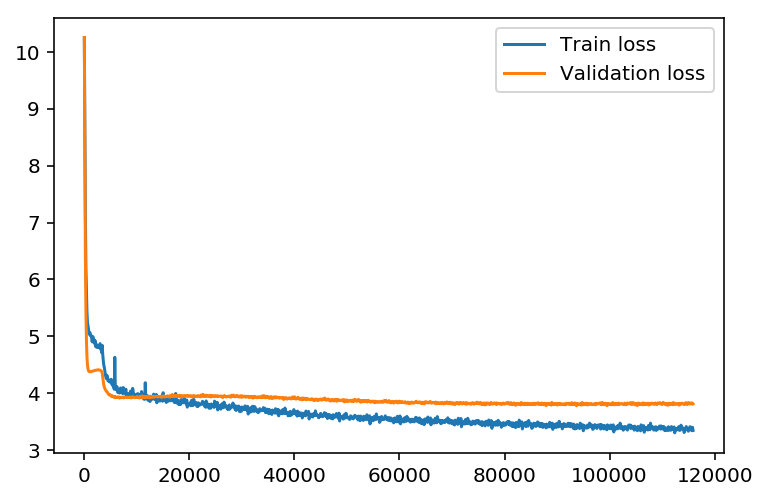

In [31]:
plt.plot(x_steps,losses["train"],label="Train loss")
plt.plot(x_steps,losses["validation"],label="Validation loss")
plt.legend()
_ = plt.ylim()

#### Saved checkpoints

Read up on saving and loading checkpoints here: https://www.tensorflow.org/programmers_guide/variables

In [32]:
checkpoints = tf.train.get_checkpoint_state('checkpoints')

## Sampling final trained model

Now that the network is trained, we'll can use it to generate new text. The idea is that we pass in a character, then the network will predict the next character. We can use the new one, to predict the next one. And we keep doing this to generate all new text. I also included some functionality to prime the network with some text by passing in a string and building up a state from that.

The network gives us predictions for each character. To reduce noise and make things a little less random, I'm going to only choose a new character from the top N most likely characters.



In [33]:
def sample(checkpoint, n_samples, lstm_size, vocab_size, prime="The ",mode="characters"):
    print(mode)
    samples = tokenize_text(prime,mode)
    model = CharRNN(len(vocab), lstm_size=lstm_size, sampling=True)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, checkpoint)
        new_state = sess.run(model.initial_state)
        for c in tokenize_text(prime,mode):
            x = np.zeros((1, 1))
            x[0,0] = vocab_to_int[c]
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

        c = pick_top_n(preds, len(vocab))
        samples.append(int_to_vocab[c])

        for i in range(n_samples):
            x[0,0] = c
            feed = {model.inputs: x,
                    model.keep_prob: 1.,
                    model.initial_state: new_state}
            preds, new_state = sess.run([model.prediction, model.final_state], 
                                         feed_dict=feed)

            c = pick_top_n(preds, len(vocab))
            samples.append(int_to_vocab[c])
        
    return ''.join(samples).replace("new_line_token","\n")

Here, pass in the path to a checkpoint and sample from the network.

In [34]:
tf.train.latest_checkpoint('checkpoints')

'checkpoints/mwords_i116000_l64.ckpt'

## Generate new text from "base" text

In [35]:

checkpoint = tf.train.latest_checkpoint('checkpoints')


samples = list()
for text in text_to_try:
    #print("------------------------",text)
    samples.append( sample(checkpoint, 500, lstm_size, len(vocab), prime=text,mode=mode))
    #print(samp)
    #print("------------------------")

words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l64.ckpt
words
INFO:tensorflow:Restoring parameters from checkpoints/mwords_i116000_l

In [36]:
for i in range(len(text_to_try)):
    text = text_to_try[i]
    generated = samples[i]
    print("------------------------",text)
    print(generated)
    print("------------------------")

------------------------ In the first place
In the first place to been be the great   of   of the   of the the most city of a own and the most world of the old and and the the most   to the other and a great world, and the great world of a the old world of the old man of   to a the    and old of the own man of a most of a most man in a   and old city with the great city to the great and in be the   of old of the  , and the great world of the most man, and the the the and and be not the great world to, I had a
   the old time and be; but of the   of old the.  to a time and not. The   of the     the great thing to a    the   of  . It of a whole   was other and and   in a great man of a the most world in the   and great old     of   to the the    the old world of the the great world of a the great and   of   of     to the   and
great, and the
the the old   of   in the most time of the most, and, in   of the   of the   and   to
   the most man of   to 
------------------------
------------

In [37]:
tf.train.get_checkpoint_state('checkpoints')

model_checkpoint_path: "checkpoints/mwords_i116000_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/mwords_i114001_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/mwords_i114501_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/mwords_i115001_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/mwords_i115501_l64.ckpt"
all_model_checkpoint_paths: "checkpoints/mwords_i116000_l64.ckpt"